In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install pygame

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 82.2 MB/s eta 0:00:00:00:0100:01


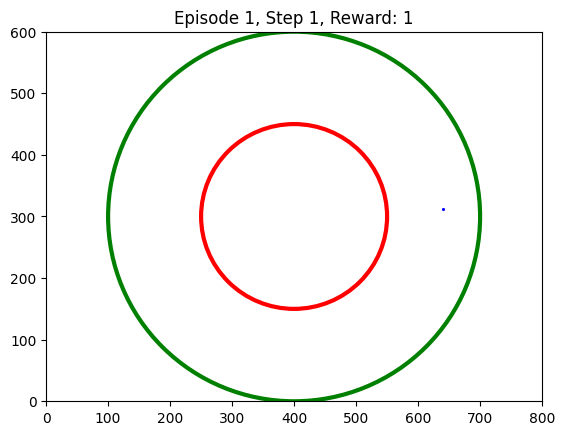

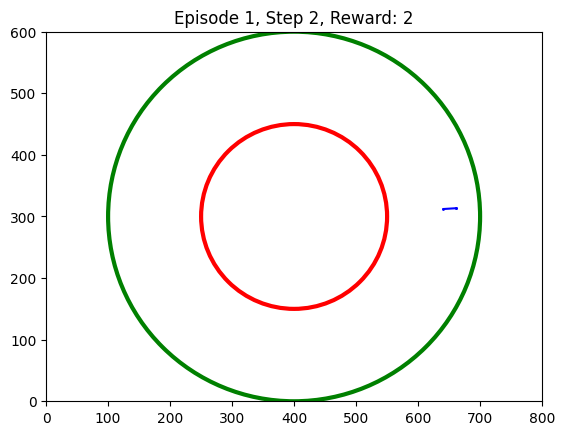

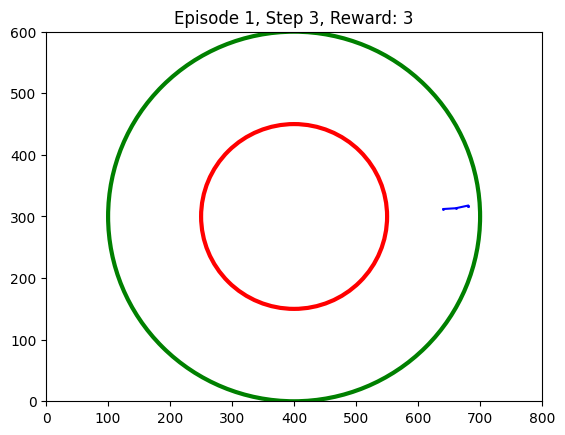

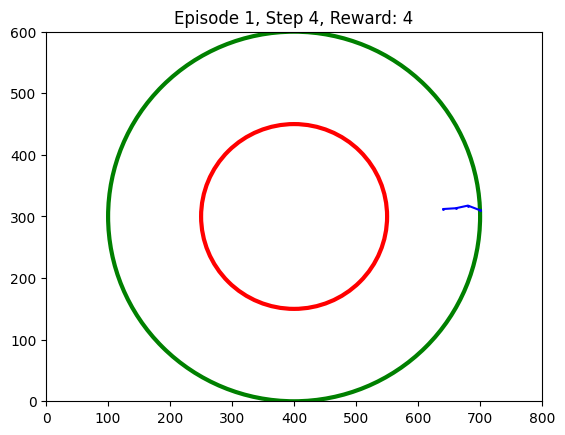

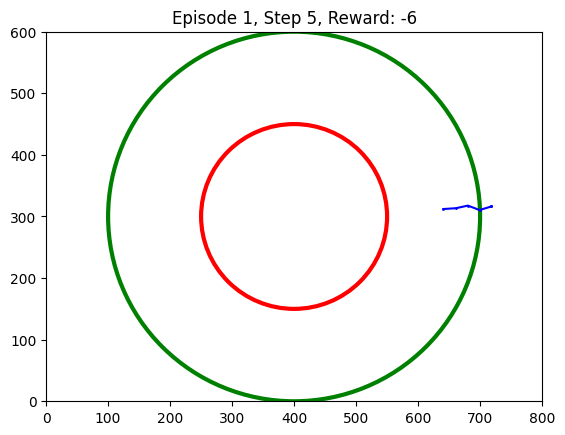

Episode 1/5, Total Reward: -6, Epsilon: 1.00


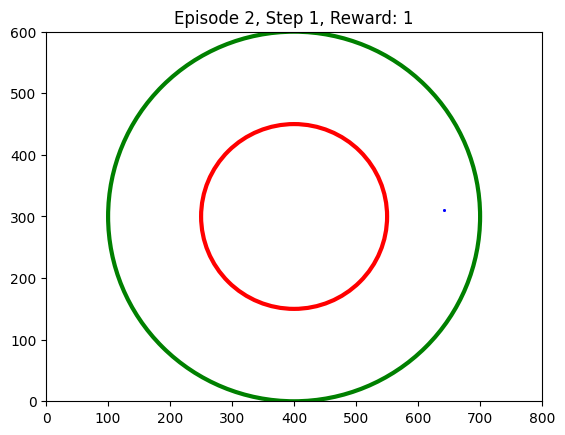

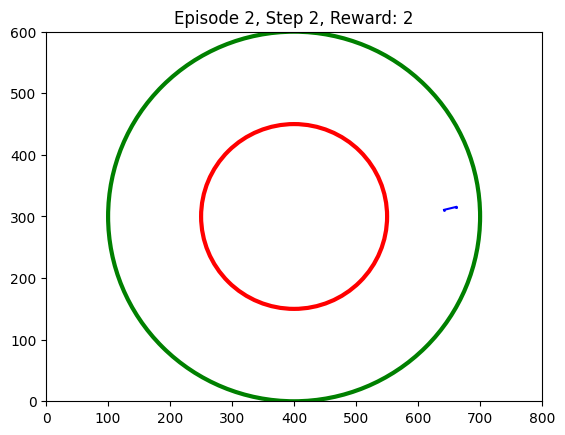

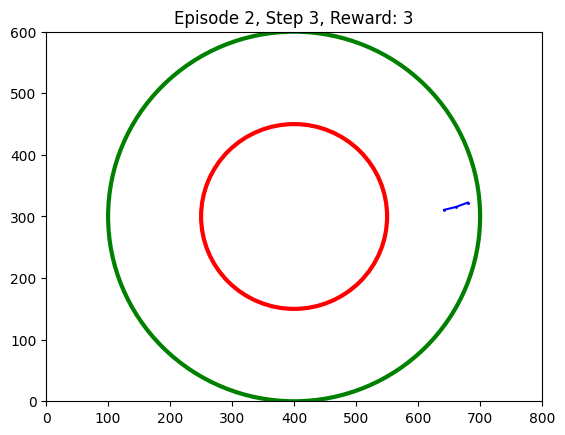

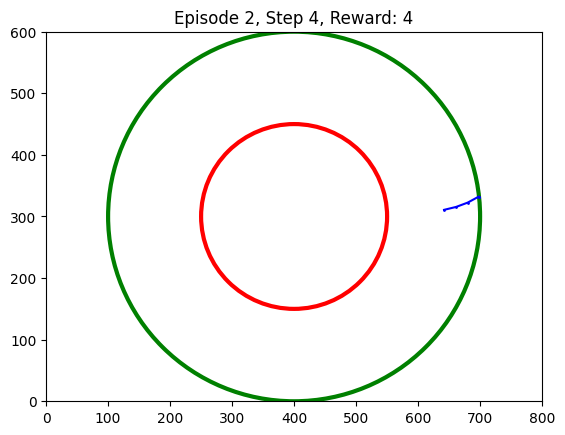

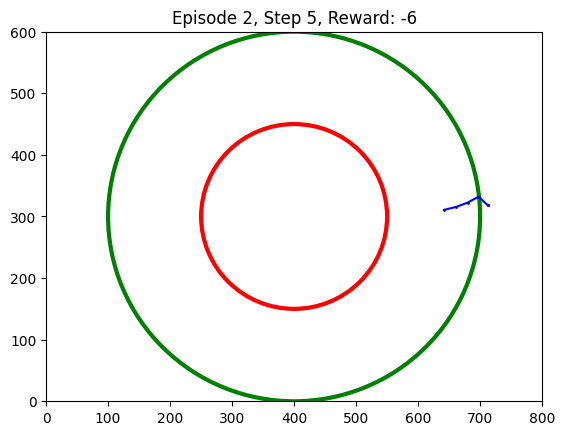

Episode 2/5, Total Reward: -6, Epsilon: 1.00


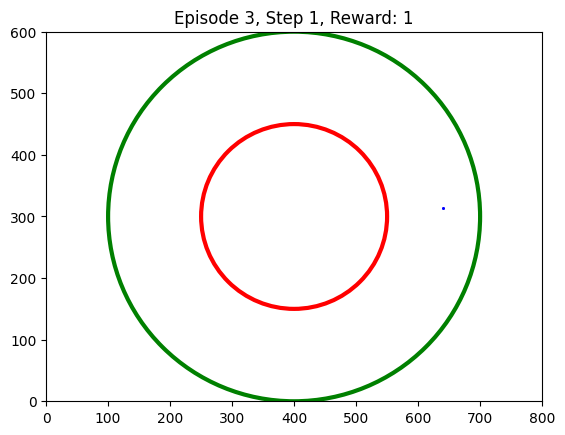

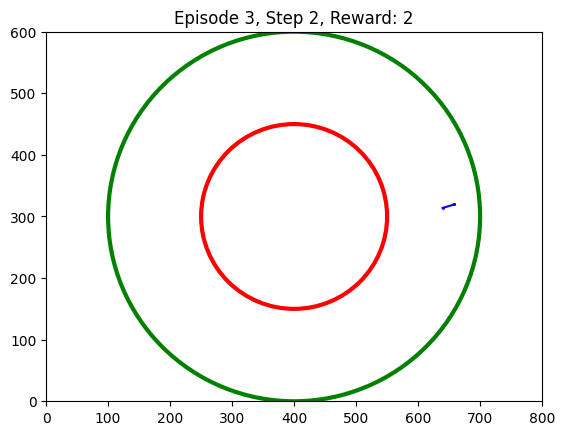

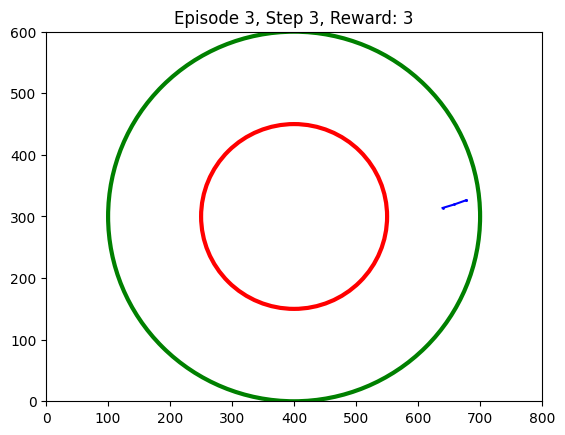

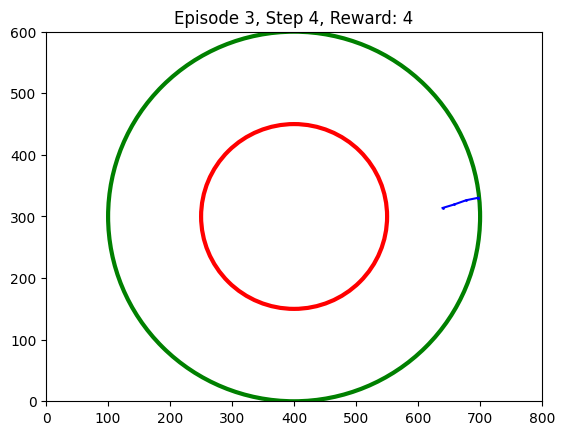

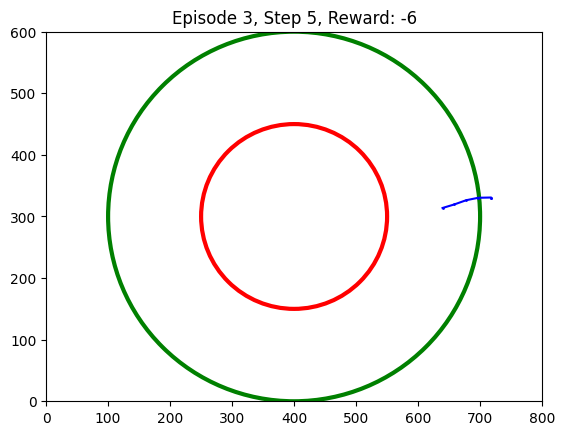

Episode 3/5, Total Reward: -6, Epsilon: 1.00


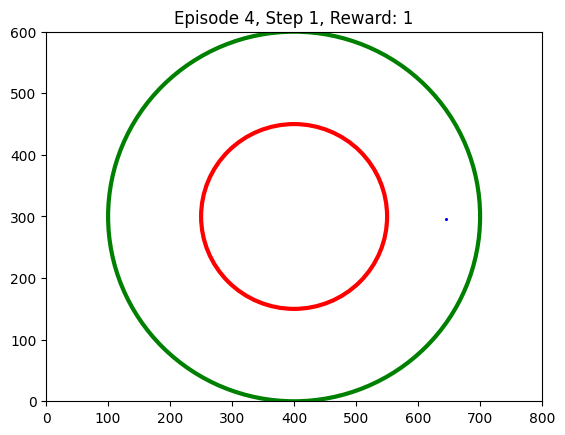

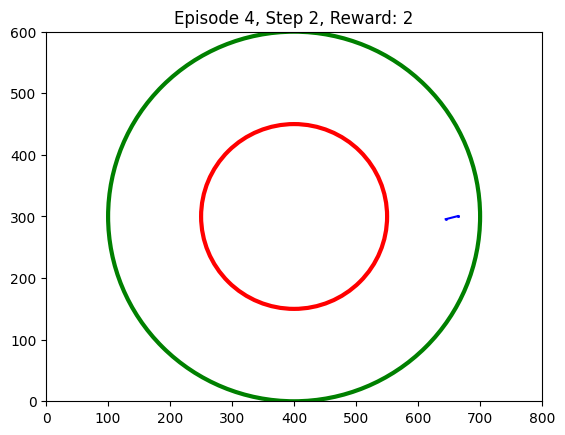

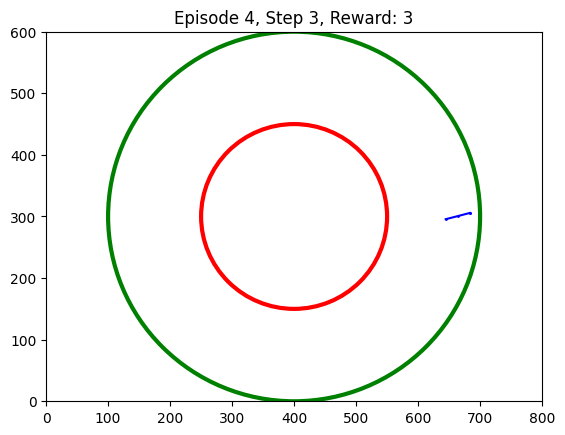

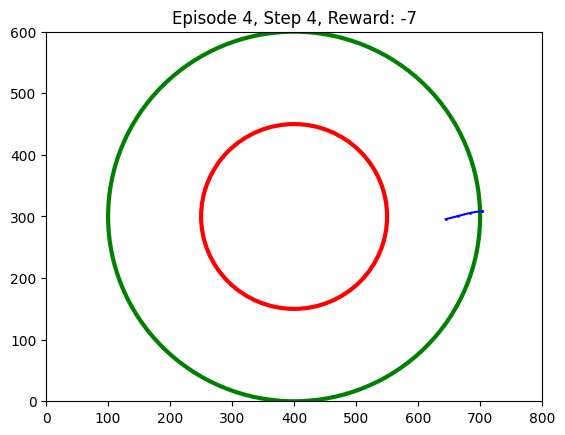

Episode 4/5, Total Reward: -7, Epsilon: 1.00


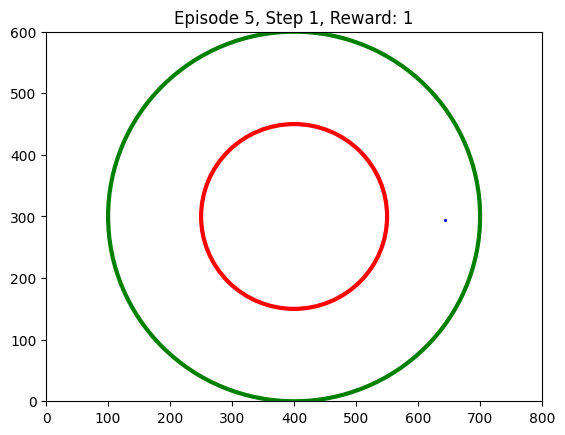

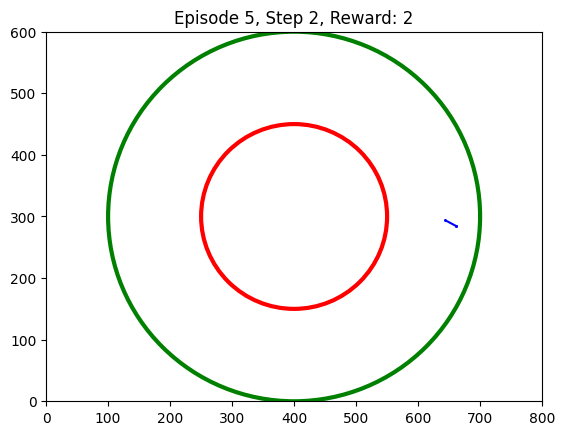

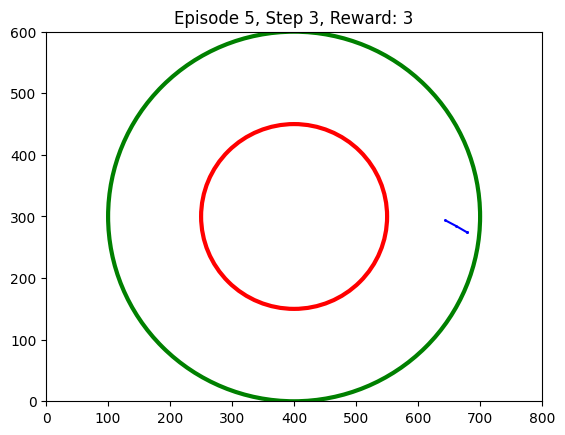

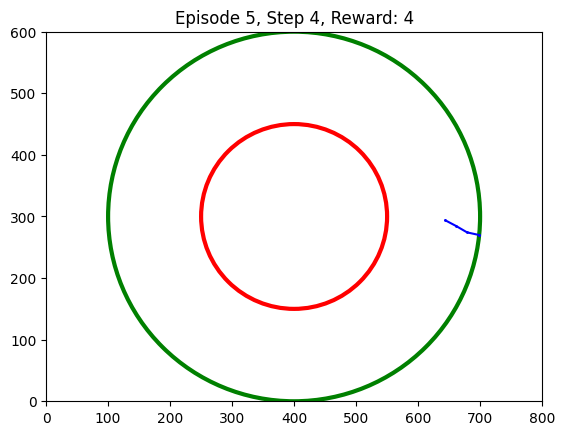

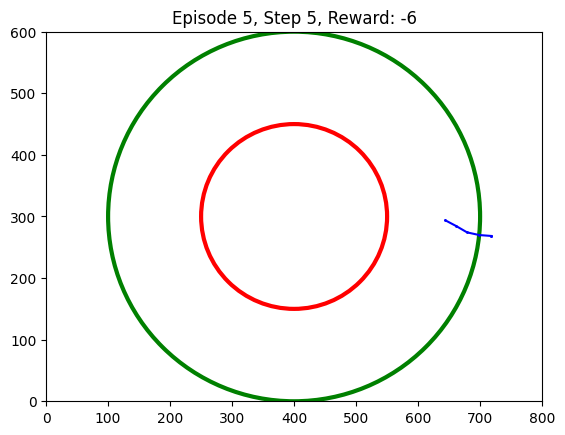

Episode 5/5, Total Reward: -6, Epsilon: 1.00


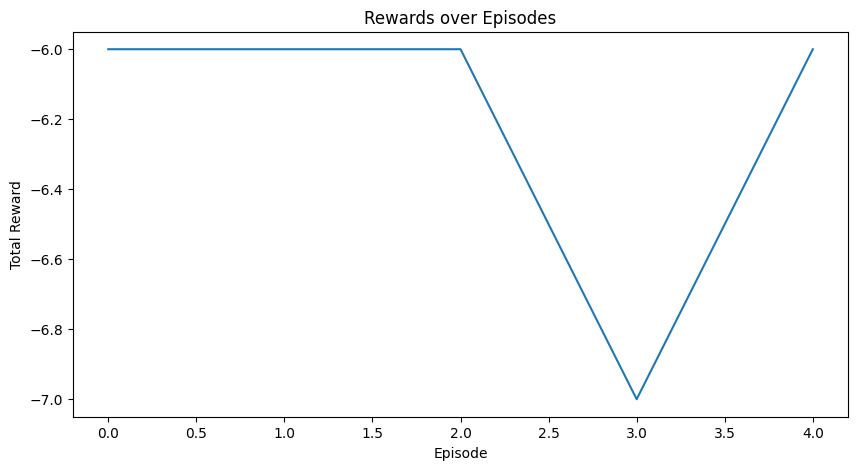

In [73]:
import numpy as np
import random
from collections import deque
from tensorflow import keras
from keras.layers import Dense
import matplotlib.pyplot as plt

# Game Constants
TRACK_WIDTH = 800
TRACK_HEIGHT = 600
CAR_SIZE = 1  # Decreased car size for a thinner appearance
CAR_SPEED = 20  # Increased speed for faster movement
OUTER_RADIUS = 300
INNER_RADIUS = 150
MAX_EPISODES = 5  # Number of training episodes
MAX_STEPS = 50  # Steps per episode
GAMMA = 0.95  # Discount factor
EPSILON = 1.0  # Initial exploration rate
EPSILON_DECAY = 0.995  # Decay factor for epsilon
MIN_EPSILON = 0.01  # Minimum exploration rate
LEARNING_RATE = 0.001
MEMORY_SIZE = 2000
BATCH_SIZE = 32

# Racing Game Environment
class RacingGame:
    def __init__(self):
        self.reset()

    def reset(self):
        # Fixed starting position just outside the inner boundary, within the outer boundary
        angle = 0  # Fixed angle for consistent starting position
        radius = (INNER_RADIUS + OUTER_RADIUS) / 2
        self.state = [
            TRACK_WIDTH / 2 + radius * np.cos(angle),
            TRACK_HEIGHT / 2 + radius * np.sin(angle)
        ]
        return self.state

    def step(self, steering_angle):
        self.state[0] += CAR_SPEED * np.cos(steering_angle)
        self.state[1] += CAR_SPEED * np.sin(steering_angle)
        x_center, y_center = TRACK_WIDTH / 2, TRACK_HEIGHT / 2
        dist_from_center = np.sqrt((self.state[0] - x_center) ** 2 + (self.state[1] - y_center) ** 2)
        
        # Check if the car is out of bounds
        if dist_from_center > OUTER_RADIUS or dist_from_center < INNER_RADIUS:
            return self.state, -10, True  # Off track, negative reward
        return self.state, 1, False  # On track, positive reward

# DQN Agent
class DQNAgent:
    def __init__(self):
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.epsilon = EPSILON

    def _build_model(self):
        model = keras.Sequential([
            Dense(24, input_dim=2, activation='relu'),
            Dense(24, activation='relu'),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse')
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.uniform(-np.pi / 4, np.pi / 4)  # Explore: random action
        q_values = self.model.predict(np.array([state]))
        return q_values[0][0]  # Exploit: best action

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += GAMMA * np.amax(self.target_model.predict(np.array([next_state]))[0])
            target_f = self.model.predict(np.array([state]))
            target_f[0][0] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)
        if self.epsilon > MIN_EPSILON:
            self.epsilon *= EPSILON_DECAY

# Train the DQN Agent with Visualization of Every Step
def train_dqn():
    agent = DQNAgent()
    game = RacingGame()
    rewards_per_episode = []

    for episode in range(MAX_EPISODES):
        state = game.reset()
        total_reward = 0
        trajectory_x = []  # Stores x-coordinates of car's path
        trajectory_y = []  # Stores y-coordinates of car's path

        for step in range(MAX_STEPS):
            action = agent.act(state)
            next_state, reward, done = game.step(action)
            total_reward += reward
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()

            # Append the current position to the trajectory lists
            trajectory_x.append(state[0])
            trajectory_y.append(state[1])

            # Plot the donut track and the entire path
            plt.clf()
            plt.xlim(0, TRACK_WIDTH)
            plt.ylim(0, TRACK_HEIGHT)
            outer_circle = plt.Circle((TRACK_WIDTH / 2, TRACK_HEIGHT / 2), OUTER_RADIUS, color='g', fill=False, lw=3)
            inner_circle = plt.Circle((TRACK_WIDTH / 2, TRACK_HEIGHT / 2), INNER_RADIUS, color='r', fill=False, lw=3)
            plt.gca().add_artist(outer_circle)
            plt.gca().add_artist(inner_circle)
            plt.plot(trajectory_x, trajectory_y, 'b-o', markersize=CAR_SIZE)  # Draw path so far
            plt.plot(state[0], state[1], 'bo', markersize=CAR_SIZE)  # Plot the car with the same size as CAR_SIZE
            plt.title(f"Episode {episode + 1}, Step {step + 1}, Reward: {total_reward}")
            plt.pause(0.05)  # Pause briefly to update plot

            if done:
                break

        # Update the target network and log episode reward
        agent.update_target_model()
        rewards_per_episode.append(total_reward)
        print(f"Episode {episode + 1}/{MAX_EPISODES}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

    return rewards_per_episode

# Run the training with step-by-step visualization
rewards = train_dqn()

# Plot Rewards Over Episodes
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards over Episodes")
plt.show()
